In [1]:
import os
import pathlib
from typing import Union
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, EfficientNetB3, InceptionV3, EfficientNetB5, VGG16

In [3]:
tf.random.set_seed(32167)

In [4]:
def plot_loss_curves(history: Any) -> None:
    """
    Plots the curves of both loss and accuracy using Seaborn with improved formatting and annotated values
    
    Args:
    - history (Any): History object returned by model.fit()
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(loss))

    # Set Seaborn style with dashed grid lines for specific intervals on y-axis
    sns.set_style("whitegrid", {'grid.linestyle': '--'})

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plotting loss
    sns.lineplot(x=epochs, y=loss, label='Training Loss', ax=axes[0], linewidth=2, color='blue')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', ax=axes[0], linewidth=2, color='orange')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylim(0, 1.05)  # Set y-axis limits from 0 to 1.05
    axes[0].set_yticks([i * 0.2 for i in range(6)])  # Set y-axis ticks at 0.2 intervals
    axes[0].legend()

    for i in range(0, len(loss), 3):  # Annotate every 3rd epoch for training loss
        axes[0].annotate(f'{loss[i]:.2f}', (i, loss[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
    for i in range(0, len(val_loss), 3):  # Annotate every 3rd epoch for validation loss
        axes[0].annotate(f'{val_loss[i]:.2f}', (i, val_loss[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontweight='bold')

    # Plotting accuracy
    sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy', ax=axes[1], linewidth=2, color='blue')
    sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy', ax=axes[1], linewidth=2, color='orange')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylim(0, 1.05)  # Set y-axis limits from 0 to 1.05
    axes[1].set_yticks([i * 0.2 for i in range(6)])  # Set y-axis ticks at 0.2 intervals
    axes[1].legend()

    for i in range(0, len(accuracy), 3):  # Annotate every 3rd epoch for training accuracy
        axes[1].annotate(f'{accuracy[i]:.2f}', (i, accuracy[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
    for i in range(0, len(val_accuracy), 3):  # Annotate every 3rd epoch for validation accuracy
        axes[1].annotate(f'{val_accuracy[i]:.2f}', (i, val_accuracy[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()


In [5]:
def create_tensorboard_callback(dir_name: str, experiment_name: str) -> tf.keras.callbacks.TensorBoard:
    """
    Creates a TensorBoard callback instance to store log files.

    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

    Args:
    - dir_name (str): target directory to store TensorBoard log files
    - experiment_name (str): name of experiment directory (e.g. efficientnet_model_1)
    
    Returns:
    - tensorboard_callback (tf.keras.callbacks.TensorBoard): TensorBoard callback instance
    """
    log_dir = f"{dir_name}/{experiment_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [6]:
# Get the current date and time
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
timestamp

'2024-01-06_22-44-37'

In [7]:
models_path = pathlib.Path(r"C:\Users\KonuTech\machine-learning-zoomcamp-capstone-02\models")

#### Prepare training and validation data sets

In [8]:
data_path = pathlib.Path(r"C:\Users\KonuTech\machine-learning-zoomcamp-capstone-02\data\pizza_not_pizza")
class_names = [item.name for item in data_path.glob('*')]
print(class_names)

['not_pizza', 'pizza']


In [9]:
data_gen = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2
)

In [10]:
training_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'training',
    class_mode = 'binary'
)

Found 1574 images belonging to 2 classes.


In [11]:
validation_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'validation',
    class_mode = 'binary'
)

Found 392 images belonging to 2 classes.


#### Create checkpoint callback

In [12]:
checkpoint_path = "pizza_classification_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [13]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

#### Model 1

In [15]:
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4128      
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 1)                 1577089   
                                                                 
Total params: 1,581,633
Trainable params: 1,581,633
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_1.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

history = model_1.fit(
    training_data,
    epochs= 5,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-224437
Epoch 1/5
50/50 [==============================] - 36s 706ms/step - loss: 2.4558 - accuracy: 0.5273 - val_loss: 0.6895 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 34s 674ms/step - loss: 0.6339 - accuracy: 0.6741 - val_loss: 0.5984 - val_accuracy: 0.6939 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 33s 653ms/step - loss: 0.5011 - accuracy: 0.7903 - val_loss: 0.6086 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 33s 654ms/step - loss: 0.2467 - accuracy: 0.9288 - val_loss: 0.6307 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - 33s 658ms/step - loss: 0.0834 - accuracy: 0.9828 - val_loss: 0.6594 - val_accuracy: 0.6939 - lr: 0.0010


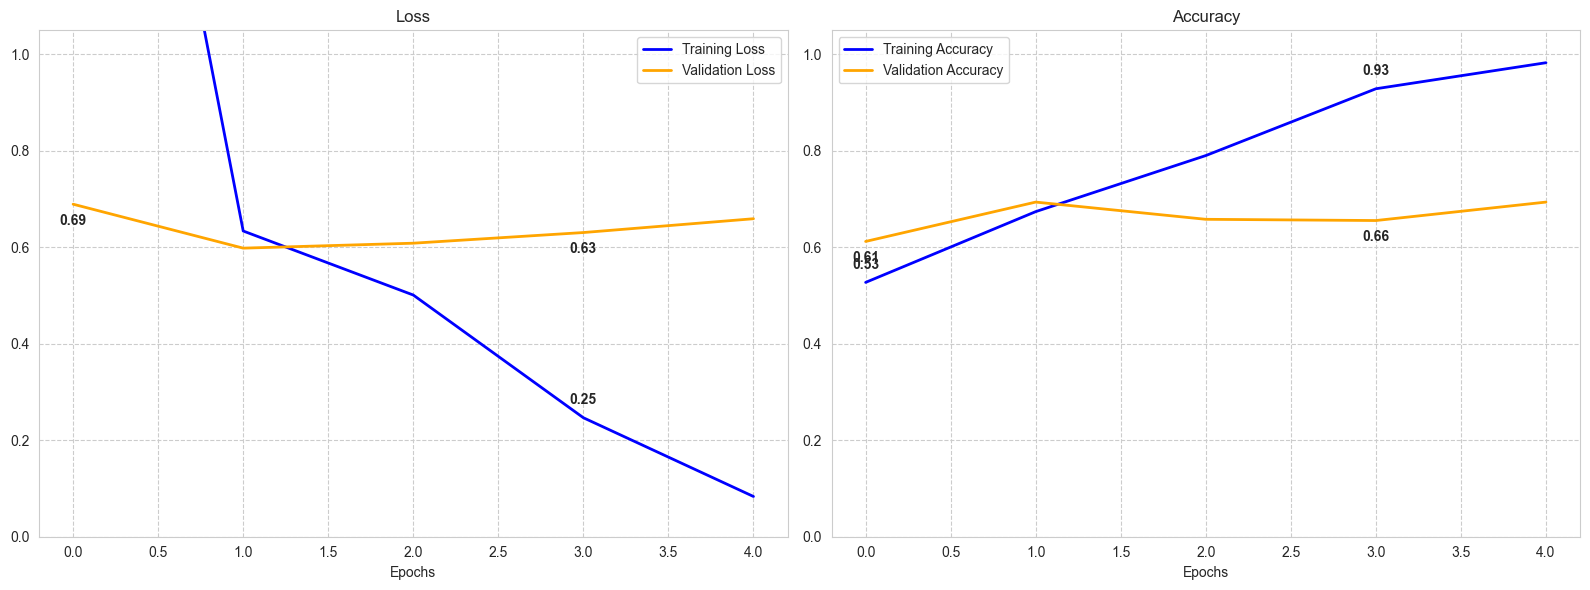

In [17]:
plot_loss_curves(history)

#### Model 2

In [18]:
model_2 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2), # It will reduce the number of features by half
        Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model_2.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

history = model_1.fit(
    training_data,
    epochs= 5,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-224726
Epoch 1/5
50/50 [==============================] - 35s 693ms/step - loss: 0.0248 - accuracy: 0.9994 - val_loss: 0.6698 - val_accuracy: 0.6862 - lr: 2.0000e-04
Epoch 2/5
40/50 [=======================>......] - ETA: 6s - loss: 0.0183 - accuracy: 0.9992

In [ ]:
plot_loss_curves(history)

#### Model 3

In [ ]:
augmentations = dict(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
data_gen_augmented = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2,
    **augmentations
)

In [ ]:
# augmented Trining data
training_data_augmented = data_gen_augmented.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'training',class_mode = 'binary'
)

In [ ]:
# non augmented Validation data
val_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'validation',
    class_mode = 'binary'
)

In [ ]:
model_3 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_3.summary()

In [ ]:
model_3.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [ ]:
history = model_3.fit(
    training_data_augmented, # changing the training data
    epochs= 5,
    steps_per_epoch = len(training_data_augmented),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Model 4

In [ ]:
model_4 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_4.summary()

In [ ]:
model_4.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model_4.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Model 5

In [ ]:
# Load pre-trained Xception model without the top (fully connected layers)
base_model_xception = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers in the base Xception model
base_model_xception.trainable = False

In [ ]:
model_5 = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

model_5.summary()

In [ ]:
model_5.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model_5.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Model 6

In [ ]:
base_model_efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet.trainable = False

In [ ]:
model_efficientnet = Sequential([
    base_model_efficientnet,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_efficientnet.summary()

In [ ]:
model_efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_efficientnet.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Model 7

In [ ]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

In [ ]:
model_inception = Sequential([
    base_model_inception,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_inception.summary()

In [ ]:
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_inception.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Model 8

In [ ]:
base_model_efficientnet_b5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet_b5.trainable = False

In [ ]:
model_efficientnet_b5 = Sequential([
    base_model_efficientnet_b5,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_efficientnet_b5.summary()

In [ ]:
model_efficientnet_b5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_efficientnet_b5.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

#### Model 9

In [ ]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False

In [ ]:
model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_vgg16.summary()

In [ ]:
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_vgg16.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

In [ ]:
plot_loss_curves(history)

#### Save a model

In [ ]:
model_inception.save(f"{models_path}/model_inception_{timestamp}.keras")

#### Model evaluation

In [ ]:
training_score = model.evaluate(training_data, verbose= 1)
validation_score = model.evaluate(validation_data, verbose= 1)

print("Validation Loss: ", validation_score[0])
print("Validation Accuracy: ", validation_score[1])